<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/354_two_groups.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(two_groups_comparison_notebook)=
# Confronto tra due gruppi

L'obiettivo di questo capitolo è di ampliare la discussione del capitolo {ref}`bayes_one_mean_notebook`, affrontando il confronto tra le medie di due gruppi indipendenti. Per cominciare, carichiamo le librerie necessarie.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from scipy.stats import gaussian_kde
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

## Stima bayesiana e test dell'ipotesi nulla

Spesso, ci troviamo ad affrontare la necessità di confrontare due gruppi di dati. Potrebbe interessarci sapere se la media di un gruppo è maggiore o diversa rispetto a quella di un altro gruppo. Per effettuare tale confronto, è fondamentale utilizzare un modello statistico, poiché le vere differenze tra i gruppi sono spesso accompagnate da rumore di misurazione o fluttuazioni casuali del fenomeno in esame. Questo rende difficile trarre conclusioni basandosi unicamente sulle differenze calcolate dai dati osservati.

Il metodo tradizionale per confrontare statisticamente due o più gruppi è quello di utilizzare un test statistico. Questo approccio prevede l'individuazione di un'ipotesi nulla, che solitamente afferma che non ci sono differenze tra i gruppi, e l'utilizzo di una statistica test per determinare se i dati osservati sono plausibili sotto questa ipotesi. L'ipotesi nulla viene rifiutata quando la statistica test calcolata supera una soglia predefinita.

Tuttavia, i test di ipotesi possono essere complessi e i risultati spesso soggetti a interpretazioni errate. La scelta delle specifiche del test statistico (ad esempio, quale test utilizzare, quale ipotesi nulla testare, quale livello di significatività adottare) è spesso arbitraria e basata su convenzioni piuttosto che sulla specificità del problema o delle decisioni da prendere (Johnson, 1999). Inoltre, i risultati forniti dai test sono spesso indiretti, incompleti e tendono a sovrastimare le evidenze contro l'ipotesi nulla (Goodman, 1999).

Un approccio più informativo ed efficace per il confronto tra gruppi è quello basato sulla stima invece che sul test dell'ipotesi nulla, ed è guidato dalla probabilità bayesiana anziché dalla frequentista. In pratica, invece di testare se ci sono differenze tra i gruppi, si cerca di ottenere una stima di quanto siano effettivamente diversi. Questo approccio è intrinsecamente più informativo. Inoltre, viene inclusa una stima dell'incertezza associata a tale differenza, che tiene conto sia dell'incertezza dovuta alla nostra mancanza di conoscenza dei parametri del modello (incertezza epistemica) sia dell'incertezza causata dalla variabilità intrinseca del sistema (incertezza aleatoria).

## Un esempio illustrativo

In questo esempio, l'obiettivo è stimare la differenza tra le medie del quoziente di intelligenza dei bambini di due gruppi distinti in base al livello di scolarità della madre. Il primo gruppo include i bambini la cui madre non ha completato le scuole superiori, mentre il secondo gruppo comprende quelli la cui madre ha ottenuto il diploma superiore. Per questo, useremo i dati `kidiq` e un modello bayesiano al fine di ottenere una stima affidabile della differenza tra le medie dei due gruppi nella popolazione.

I dati utilizzati sono forniti da Gelman e Hill (2007) e costituiscono un sottocampione estratto dal  *National Longitudinal Survey of Youth*.

Leggiamo i dati.

In [3]:
url = "http://www.stat.columbia.edu/~gelman/arm/examples/child.iq/kidiq.dta"
df = pd.read_stata(url)
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


Il dataset contiene le seguenti colonne:

- "kid_score": il quoziente intellettivo (QI) dei bambini. È una misura dell'intelligenza del bambino.
- "mom_hs": una variabile binaria che indica se la madre del bambino ha completato o meno la scuola superiore. Può assumere i valori 0 o 1, dove 0 rappresenta "no" (la madre non ha completato la scuola superiore) e 1 rappresenta "sì" (la madre ha completato la scuola superiore).

Ci sono 93 bambini la cui madre non ha completato la scuola superiore e 341 bambini la cui madre ha ottenuto il diploma di scuola superiore.

In [4]:
df.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

Le statistiche descrittive si ottengono nel modo seguente.

In [5]:
summary_stats = [np.mean, st.stdev]
df.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

I bambini la cui madre ha completato le superiori tendono ad avere un QI maggiore di 11.8 punti rispetto ai bambini la cui madre non ha concluso le superiori.

In [9]:
89.319648 - 77.548387

11.771260999999996

Creiamo due vettori che contengono il QI dei bambini dei due gruppi.

In [6]:
# Vector of kid_score when mom_hs is 1
kid_score_mom_hs_1 = df[df["mom_hs"] == 1]["kid_score"]

# Vector of kid_score when mom_hs is 0
kid_score_mom_hs_0 = df[df["mom_hs"] == 0]["kid_score"]

Esaminiamo la distribuzione del QI nei due gruppi.

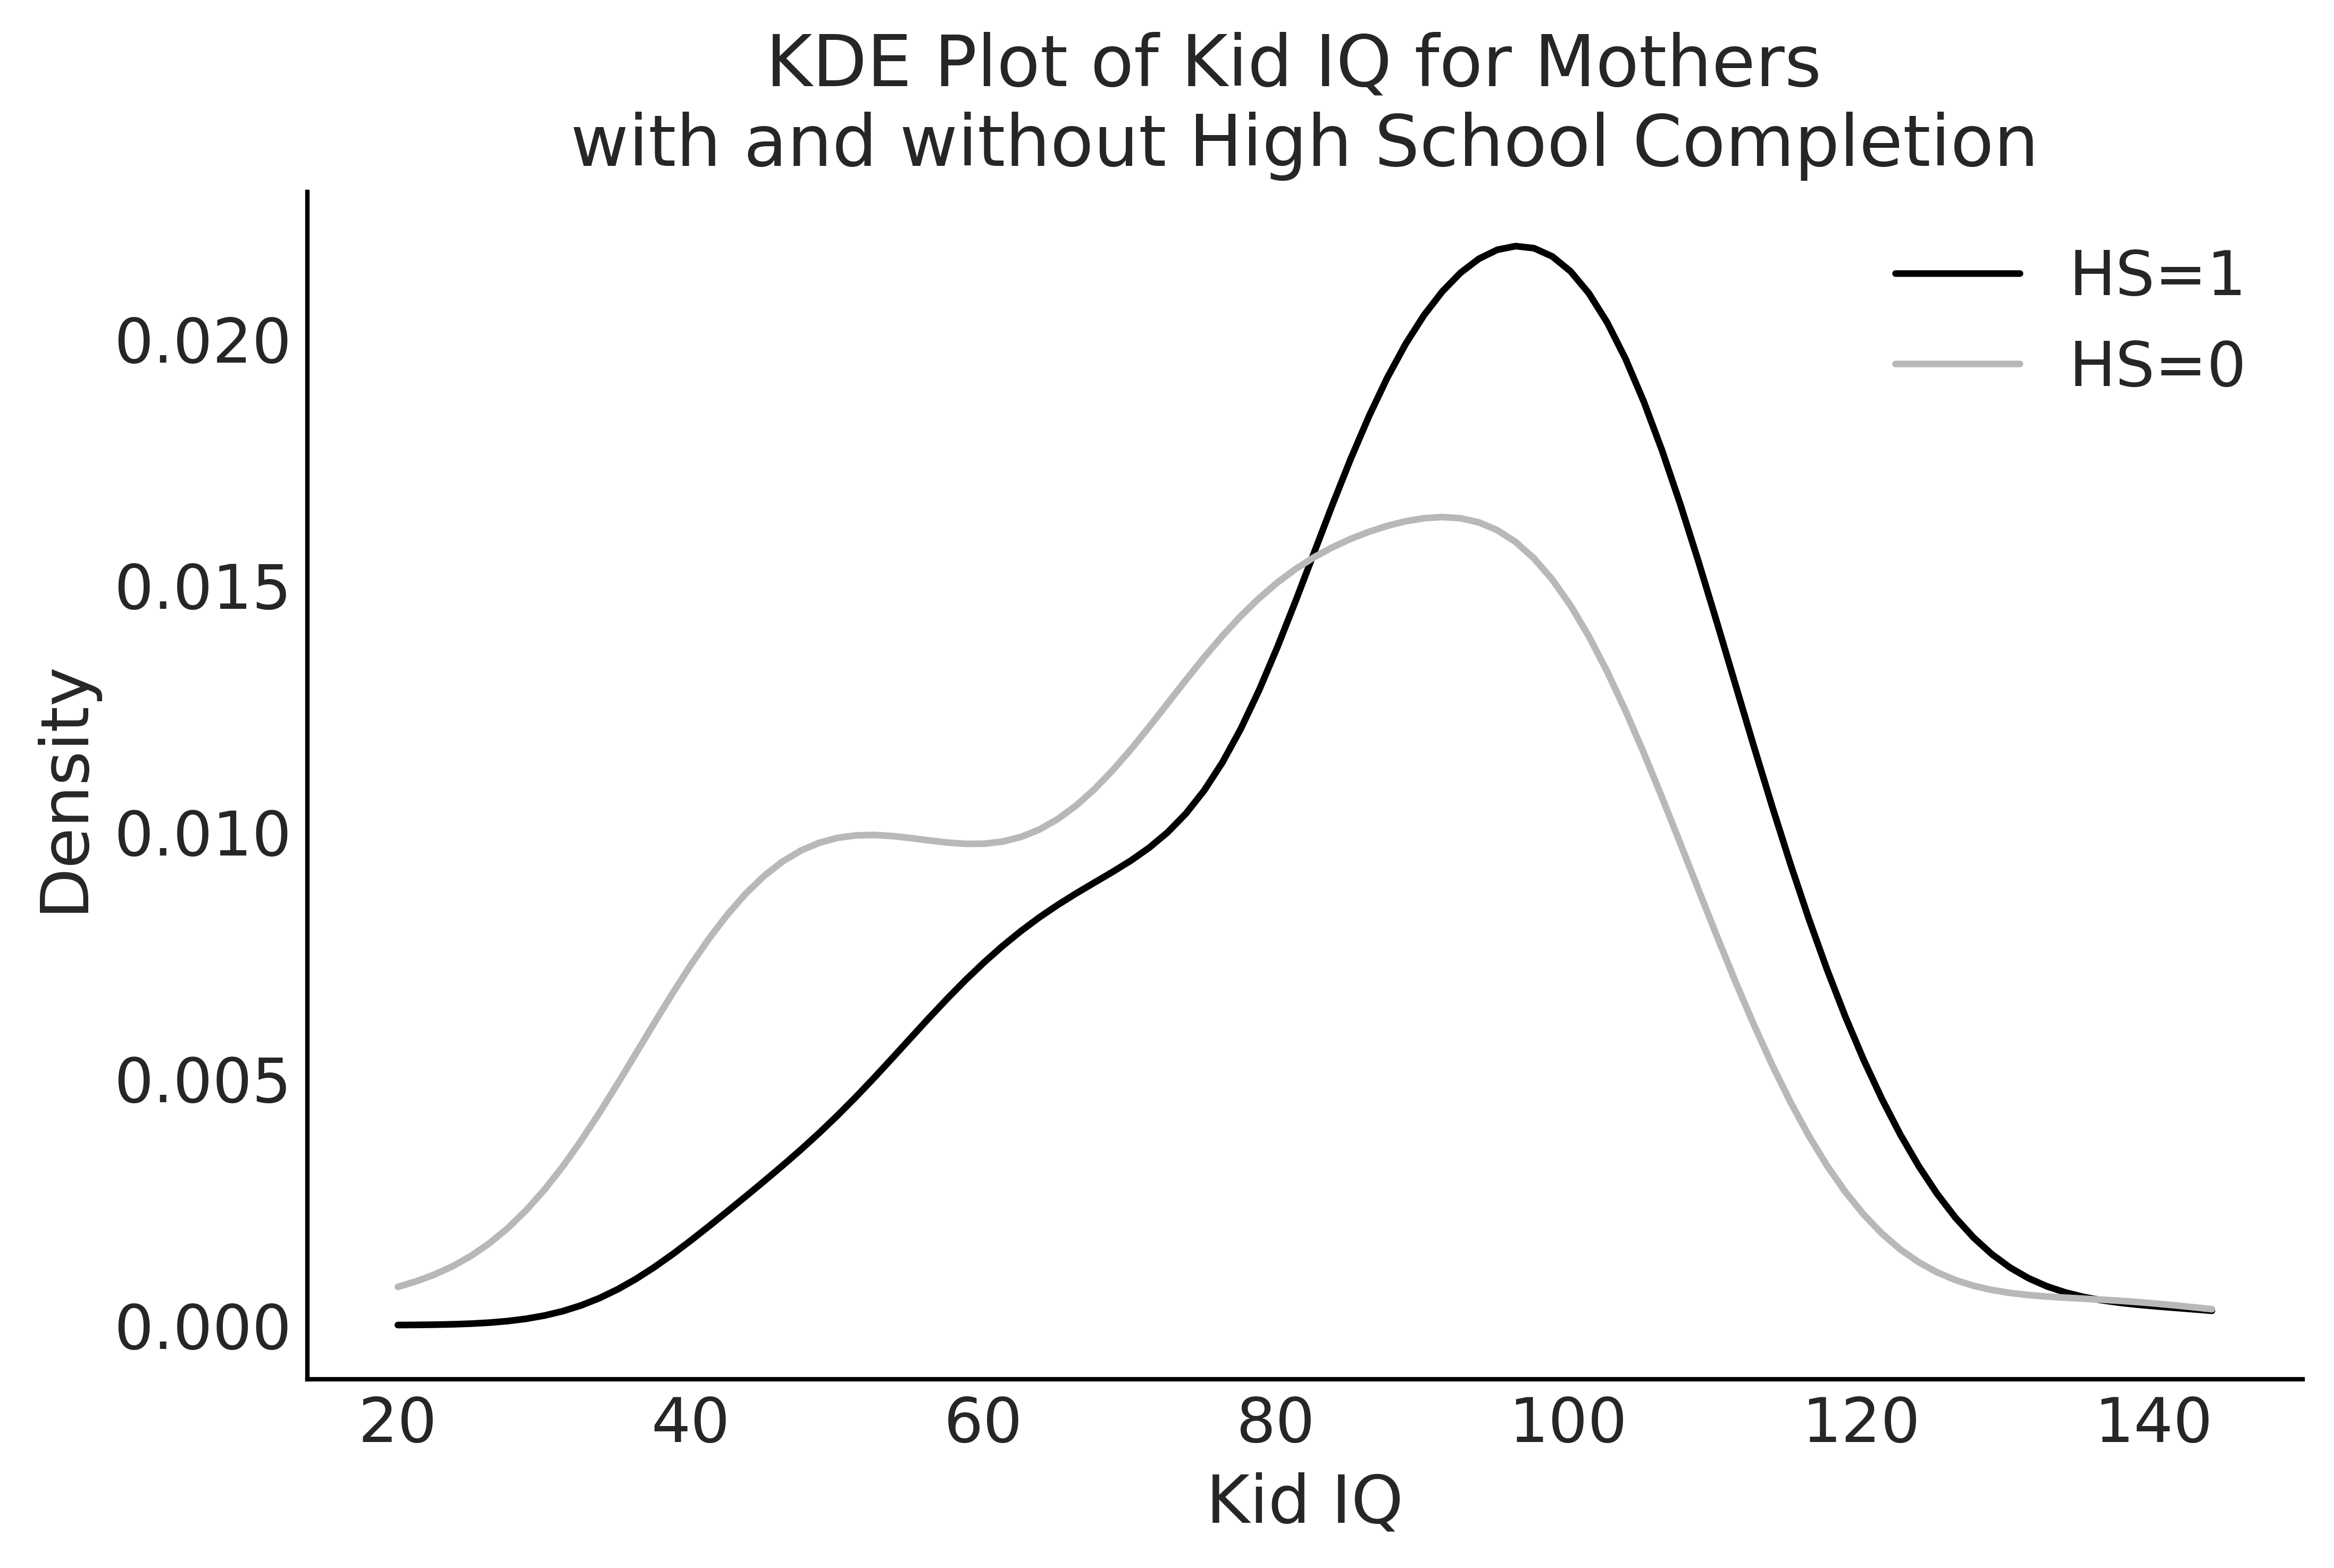

In [9]:
# Create a KDE for each group
kde_hs_1 = gaussian_kde(kid_score_mom_hs_1)
kde_hs_0 = gaussian_kde(kid_score_mom_hs_0)

# Generate x values for the plot
x_vals = np.linspace(
    min(np.min(kid_score_mom_hs_1), np.min(kid_score_mom_hs_0)),
    max(np.max(kid_score_mom_hs_1), np.max(kid_score_mom_hs_0)),
    100,
)

# Calculate KDE densities for the x values
density_hs_1 = kde_hs_1(x_vals)
density_hs_0 = kde_hs_0(x_vals)

# Create the plot
plt.title("KDE Plot of Kid IQ for Mothers \nwith and without High School Completion")
plt.xlabel("Kid IQ")
plt.ylabel("Density")

plt.plot(x_vals, density_hs_1, label="HS=1")
plt.plot(x_vals, density_hs_0, color="C3", label="HS=0")

# Show the legend
plt.legend()

## Dimensione dell'effetto 

Nel caso presente, la differenza tra le medie dei due gruppi è di 11.8 punti sulla scala del QI, e potrebbe sembrare un risultato rilevante, considerando che la metrica del QI è facilmente interpretabile. Tuttavia, è importante notare che il test utilizzato in questo studio non è il WISC, che ha una distribuzione normale con media 100 e deviazione standard 15, ma il test PIAT.

In generale, è difficile comprendere il significato di una differenza tra le medie di due gruppi quando viene presentata solo come valore assoluto, soprattutto quando le varianze dei gruppi sono diverse. Per ottenere una misura più informativa, è necessario considerare sia la differenza tra le medie dei gruppi che l'incertezza associata a queste stime delle medie della popolazione. L'indice statistico che soddisfa questo scopo è noto come "dimensione dell'effetto" (effect size).

La dimensione dell'effetto è una misura della forza dell'associazione osservata, che tiene conto sia della grandezza della differenza tra i gruppi attesi che dell'incertezza sui dati. Tra gli indici più comunemente utilizzati per quantificare la dimensione dell'effetto, vi è l'indice $d$ di Cohen. 

Nel caso di due medie, questo indice è dato da:

$$
d={\frac {{\bar {x}}_{1}-{\bar {x}}_{2}}{s}},
$$

laddove

$$
s={\sqrt {\frac {(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}}}
$$

e la varianza di ciascun gruppo è calcolata come

$$
s_{1}^{2}={\frac {1}{n_{1}-1}}\sum _{i=1}^{n_{1}}(x_{1,i}-{\bar {x}}_{1})^{2}.
$$

Solitamente, l'indice $d$ di Cohen si interpreta usando la metrica seguente:

| Dimensione dell'effetto |   $d$   |
| ----------------------- | ------- |
| Very small              | 0.01	|
| Small                   | 0.20	|
| Medim                   | 0.50	|
| Large                   | 0.80	|
| Very large              | 1.20	|
| Huge                    | 2.0     |

Per una trattazione bayesiana della stima della dimensione dell'effetto, si veda {cite}`doing_bayesian_data_an`.


## Modello bayesiano

Il modello bayesiano per il confronto tra le medie di due gruppi indipendenti comprende la definizione della verosimiglianza per i dati di ciascun gruppo e la descrizione delle distribuzioni a priori dei parametri rilevanti. Inoltre, in questo caso, abbiamo incluso anche la stima della dimensione dell'effetto, che ci permette di valutare la forza dell'associazione osservata tra i gruppi, tenendo conto dell'incertezza sui dati.

In [10]:
with pm.Model() as model:
    # Prior per la deviazione standard dei gruppi
    group1_std = pm.HalfCauchy("group1_std", beta=30)
    group0_std = pm.HalfCauchy("group0_std", beta=30)

    # Prior per la media dei gruppi
    group1_mean = pm.Normal("group1_mean", mu=df.kid_score.mean(), sigma=20)
    group0_mean = pm.Normal("group0_mean", mu=df.kid_score.mean(), sigma=20)

    # Likelihood per i dati osservati nei gruppi
    mom_hs_1 = pm.Normal(
        "mom_hs_1", mu=group1_mean, sigma=group1_std, observed=kid_score_mom_hs_1
    )
    mom_hs_0 = pm.Normal(
        "mom_hs_0", mu=group0_mean, sigma=group0_std, observed=kid_score_mom_hs_0
    )

    # Calcolare la grandezza dell'effetto
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group0_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group0_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std**2 + group0_std**2) / 2)
    )

Vediamo passo dopo passo cosa rappresenta ogni parte del modello:

1. **Prior per la deviazione standard dei gruppi (group1_std e group0_std):**
Queste sono distribuzioni Half-Cauchy che rappresentano le deviazioni standard dei punteggi dei bambini nei due gruppi. La scelta della distribuzione Half-Cauchy viene guidata dalla considerazione che le deviazioni standard non possono essere negative. Il parametro "beta" controlla la scala della distribuzione e influisce sull'incertezza associata alla deviazione standard. 
1. **Prior per la media dei gruppi (group1_mean e group0_mean):**
Queste sono distribuzioni normali che rappresentano le medie dei punteggi dei bambini nei due gruppi. La media delle distribuzioni normali è inizializzata con il valore medio dei punteggi dei bambini nell'intero dataset ("df.kid_score.mean()"), mentre il parametro "sigma" rappresenta la deviazione standard della distribuzione normale. Questo implica che si assume una distribuzione delle medie attorno alla media dei punteggi di tutti i bambini nel dataset, con una certa incertezza data dalla deviazione standard "sigma".
1. **Likelihood per i dati osservati nei gruppi (mom_hs_1 e mom_hs_0):**
Queste sono distribuzioni normali osservate che modellano i dati reali dei punteggi dei bambini nei due gruppi, a seconda che le madri abbiano completato o meno la scuola superiore. Queste distribuzioni rappresentano le stime dei punteggi dei bambini nei rispettivi gruppi, basate sulle medie e le deviazioni standard campionate dai dati. L'argomento "observed" indica che stiamo fornendo i dati osservati per le due distribuzioni normali, che vengono confrontati con i valori campionati dai modelli per calcolare la verosimiglianza dei dati rispetto alle stime dei punteggi dei bambini nei gruppi.

Nel modello, dopo aver definito le distribuzioni a priori e la verosimiglianza, viene calcolata la dimensione dell'effetto (*effect size*). Per calcolare la dimensione dell'effetto, vengono eseguite tre operazioni:

1. Differenza delle medie (`diff_of_means`): Viene calcolata la differenza tra le medie dei due gruppi (`group1_mean - group0_mean`). Questa grandezza indica quanto i punteggi del QI dei bambini nel gruppo delle madri con istruzione superiore differiscono dai punteggi dei bambini nel gruppo delle madri senza istruzione superiore.
2. Differenza delle deviazioni standard (`diff_of_stds`): Viene calcolata la differenza tra le deviazioni standard dei due gruppi (`group1_std - group0_std`). 
3. La dimensione dell'effetto è calcolata dividendo la differenza delle medie (`diff_of_means`) per la radice quadrata della media delle deviazioni standard al quadrato dei due gruppi (`np.sqrt((group1_std**2 + group0_std**2) / 2)`). Questo calcolo tiene conto sia della grandezza della differenza tra le medie che della variabilità dei dati, fornendo così un indice comprensibile della dimensione dell'effetto.

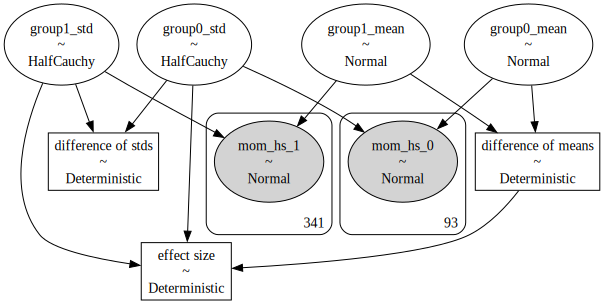

In [11]:
pm.model_to_graphviz(model)

### Distribuzioni predittive a priori

Prima di eseguire il campionamento, esaminiamo la distribuzione a priori predittiva per valutare se le scelte delle distribuzioni a priori per i parametri del modello siano adeguate.

In [12]:
with model:
    prior_samples = pm.sample_prior_predictive(30)

Sampling: [group0_mean, group0_std, group1_mean, group1_std, mom_hs_0, mom_hs_1]


Osserviamo che le distribuzioni a priori predittive per le medie dei due gruppi appaiono ragionevoli, in quanto contengono i valori delle medie campionate e includono una gamma di valori plausibili, senza essere eccessivamente estese né troppo limitate.

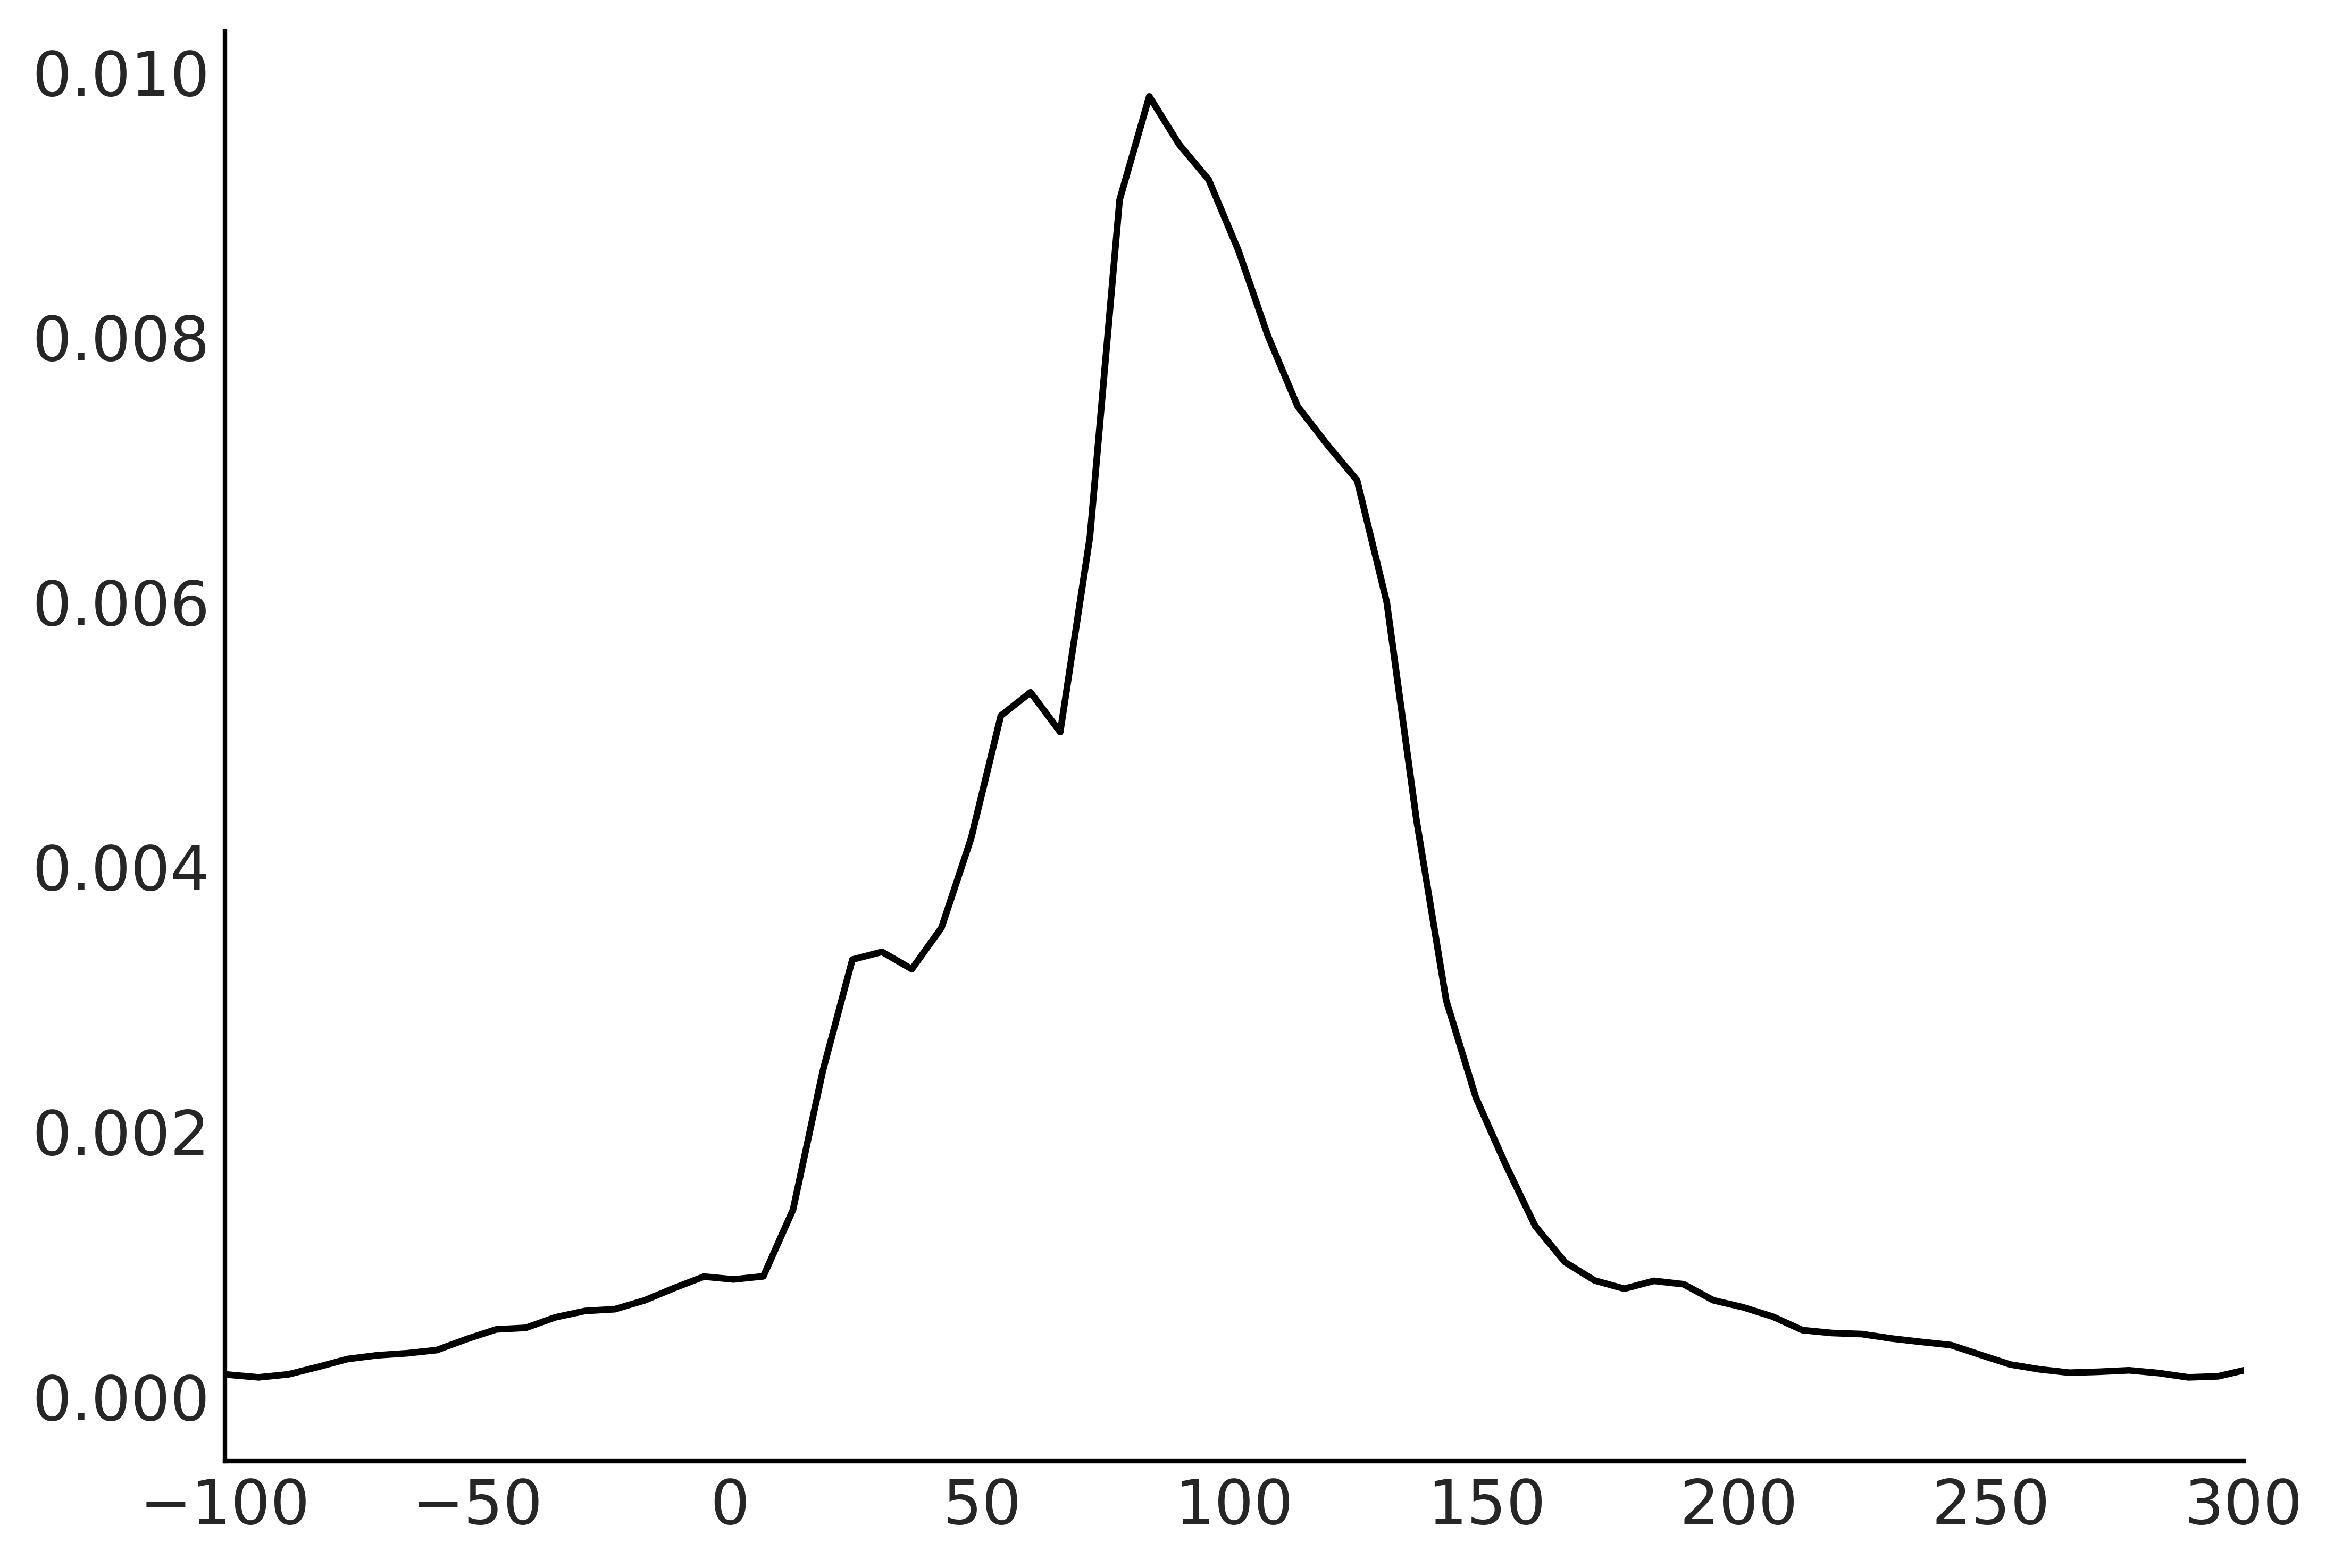

In [13]:
ax = az.plot_dist(prior_samples.prior_predictive["mom_hs_0"])
ax.set_xlim(-100, 300);

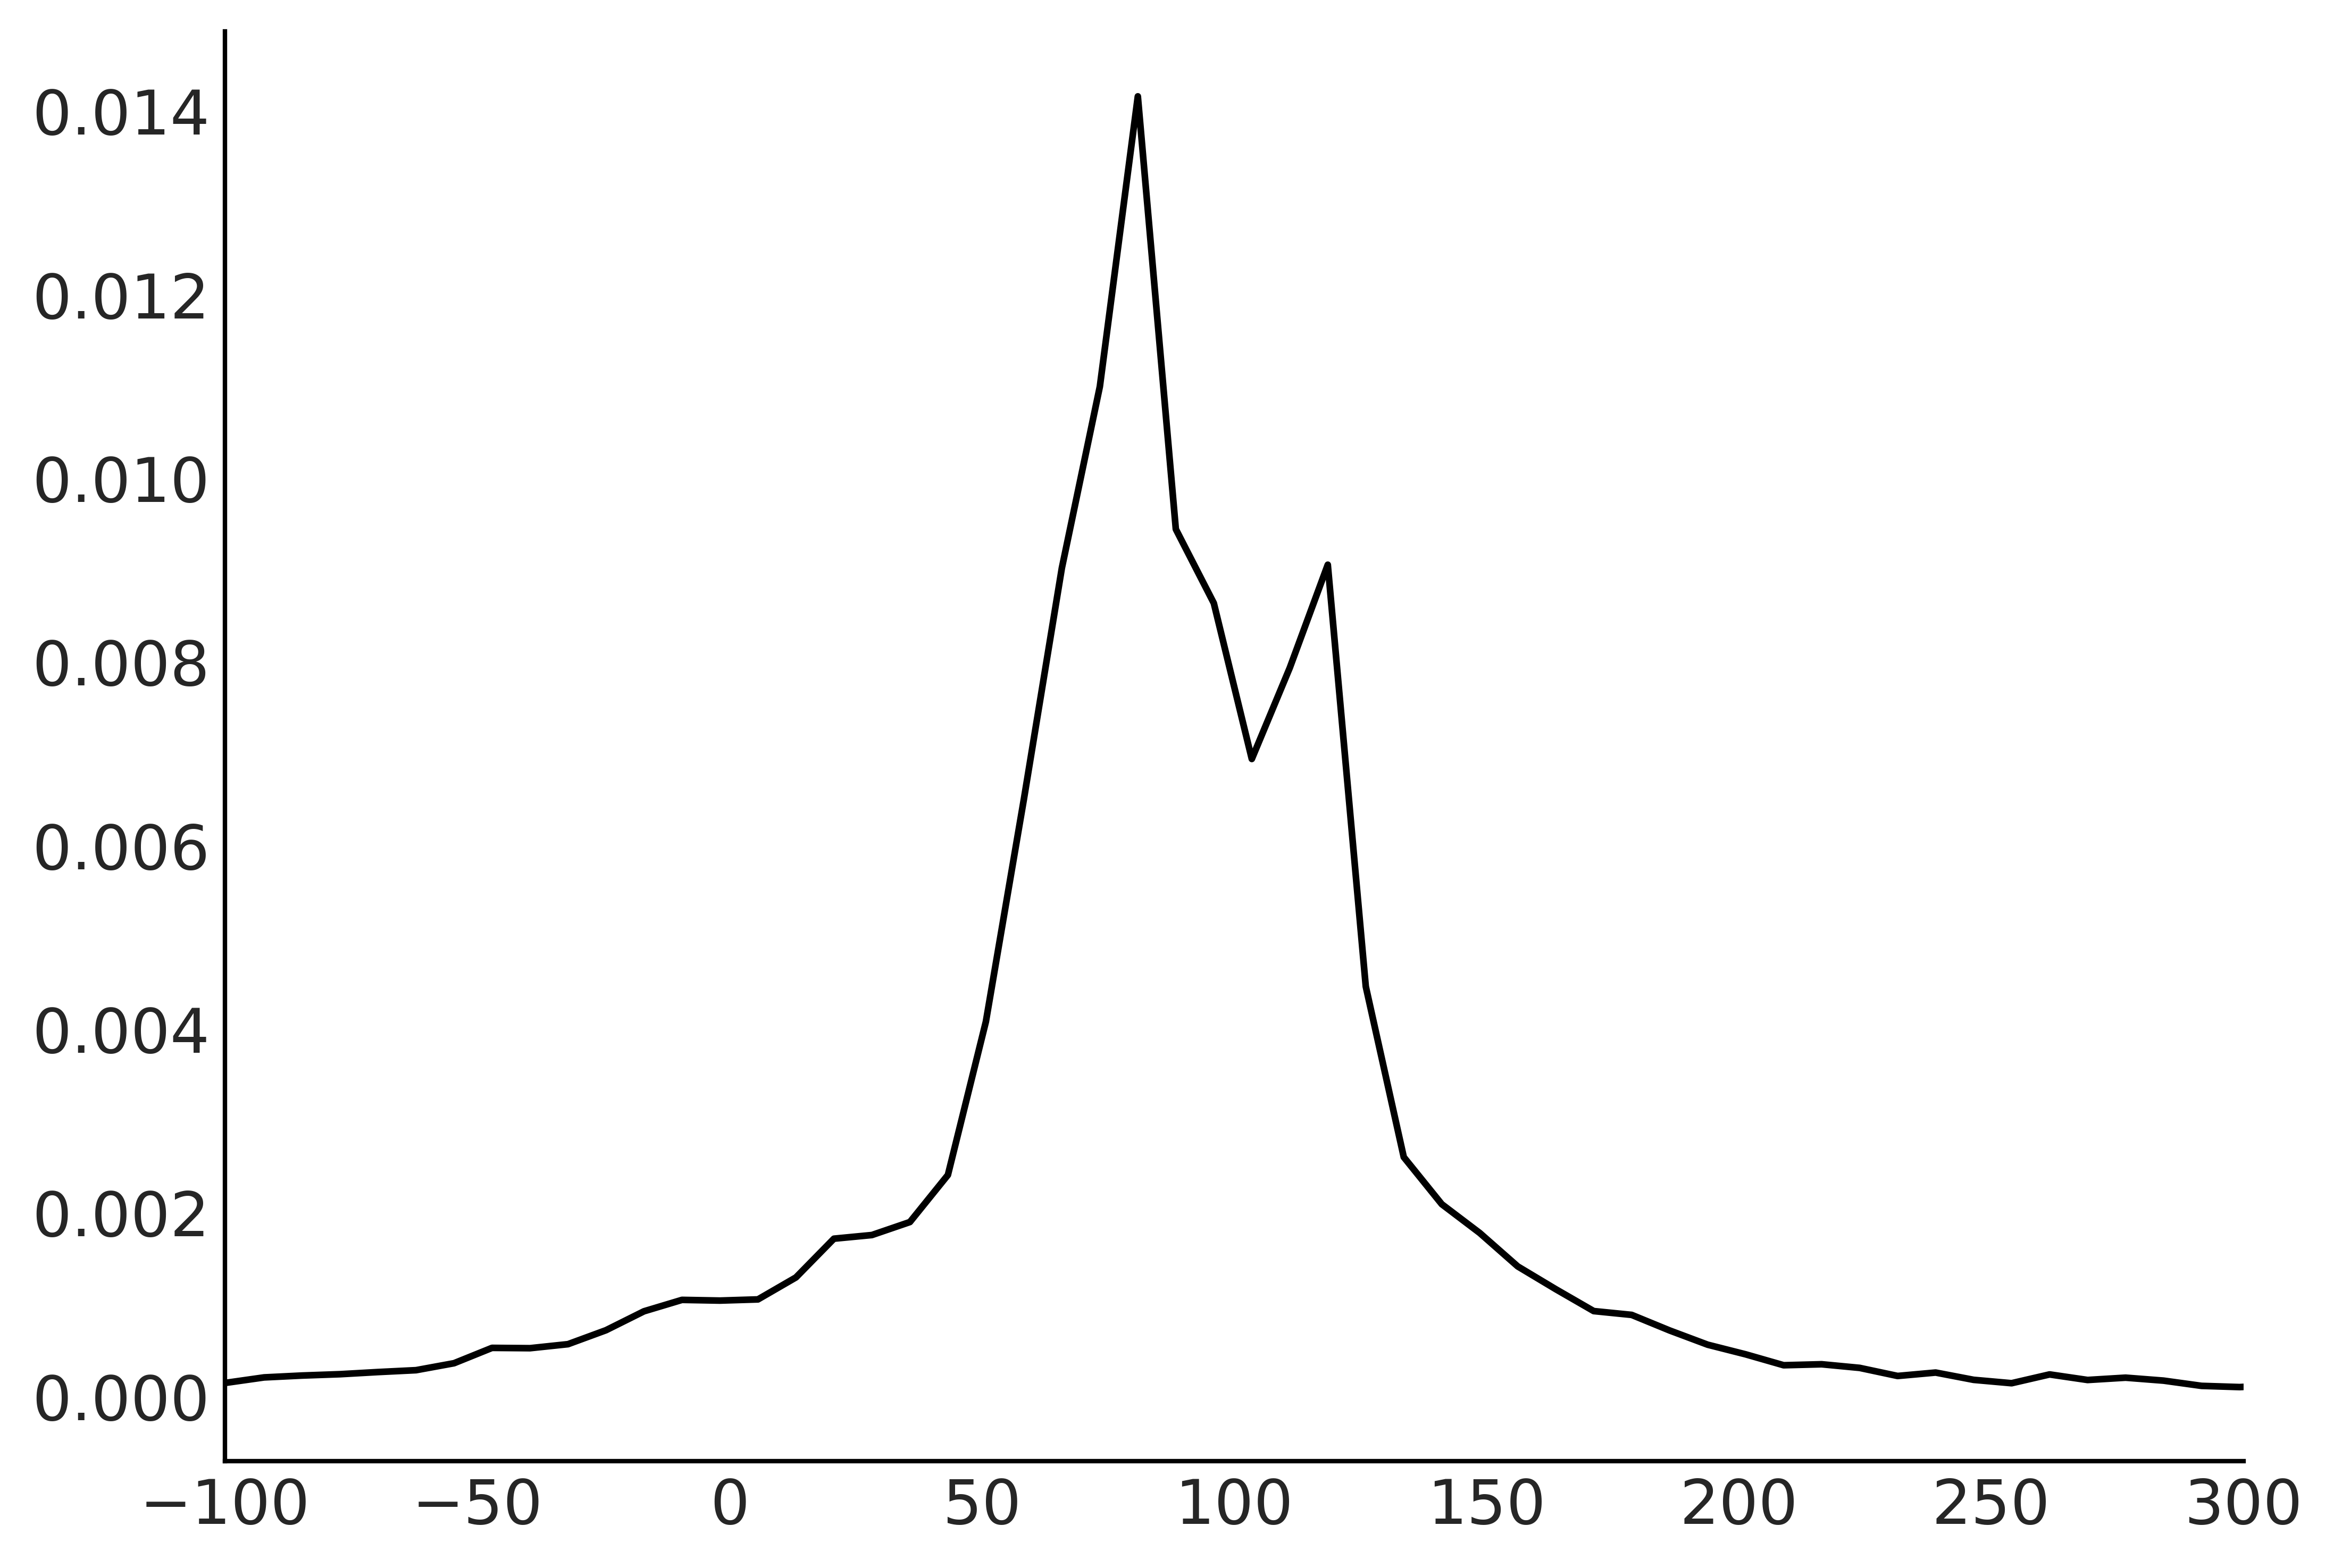

In [14]:
ax = az.plot_dist(prior_samples.prior_predictive["mom_hs_1"])
ax.set_xlim(-100, 300);

### Campionamento

Eseguiamo ora il campionamento.

In [15]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:03.085287
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:04<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:04<00:00, 447.04it/s]


Sampling time =  0:00:04.963768
Transforming variables...
Transformation time =  0:00:00.257939


### Distribuzioni a posteriori

Esaminiamo le distribuzioni a posteriori e le diagnostiche del campionamento.

In [16]:
az.plot_trace(idata, combined=True, divergences="bottom", kind="rank_bars")
plt.tight_layout()

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_6273/394998415.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Abbiamo ottenuto due distribuzioni a posteriori per ciascuno dei due parametri $\mu$ e $\sigma$ per ciascun grouppo.

Un sommario numerico delle distribuzioni a posteriori si ottiene nel modo seguente.

In [21]:
az.summary(idata, var_names=["group1_mean", "group0_mean", "group1_std", "group0_std"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group1_mean,89.339,1.057,87.311,91.226,0.013,0.009,6434.0,2980.0,1.0
group0_mean,77.731,2.388,73.473,82.493,0.029,0.020,6906.0,3187.0,1.0
group1_std,19.106,0.726,17.771,20.474,0.008,0.006,7689.0,3216.0,1.0
group0_std,22.801,1.716,19.526,25.919,0.022,0.016,6512.0,3012.0,1.0


Il nostro obiettivo è comprendere se le medie dei due gruppi sono diverse, e l'incertezza associata alla stima a posteriori del parametro `diff_of_means` è fondamentale per rispondere a questa domanda. Se l'intervallo di credibilità associato a `diff_of_means` non include lo 0, allora possiamo concludere con un certo grado di sicurezza che le medie dei due gruppi sono diverse. In altre parole, se l'intervallo di credibilità non contiene lo 0, allora ci sono prove convincenti che le medie dei due gruppi sono diverse.

In [22]:
az.summary(idata, var_names=["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,11.608,2.593,6.547,16.398,0.030,0.022,7473.0,3020.0,1.0
difference of stds,-3.695,1.863,-7.126,-0.309,0.023,0.020,7020.0,2937.0,1.0
effect size,0.553,0.127,0.316,0.799,0.001,0.001,7465.0,2392.0,1.0


Nel caso presente, l'intervallo di credibilità al 94% non include lo 0. Pertanto, possiamo concludere, con un livello di sicurezza soggettivo del 94%, che il QI dei bambini le cui madri hanno completato le scuole superiori tende ad essere più elevato rispetto a quello dei bambini le cui madri non hanno completato le scuole superiori.

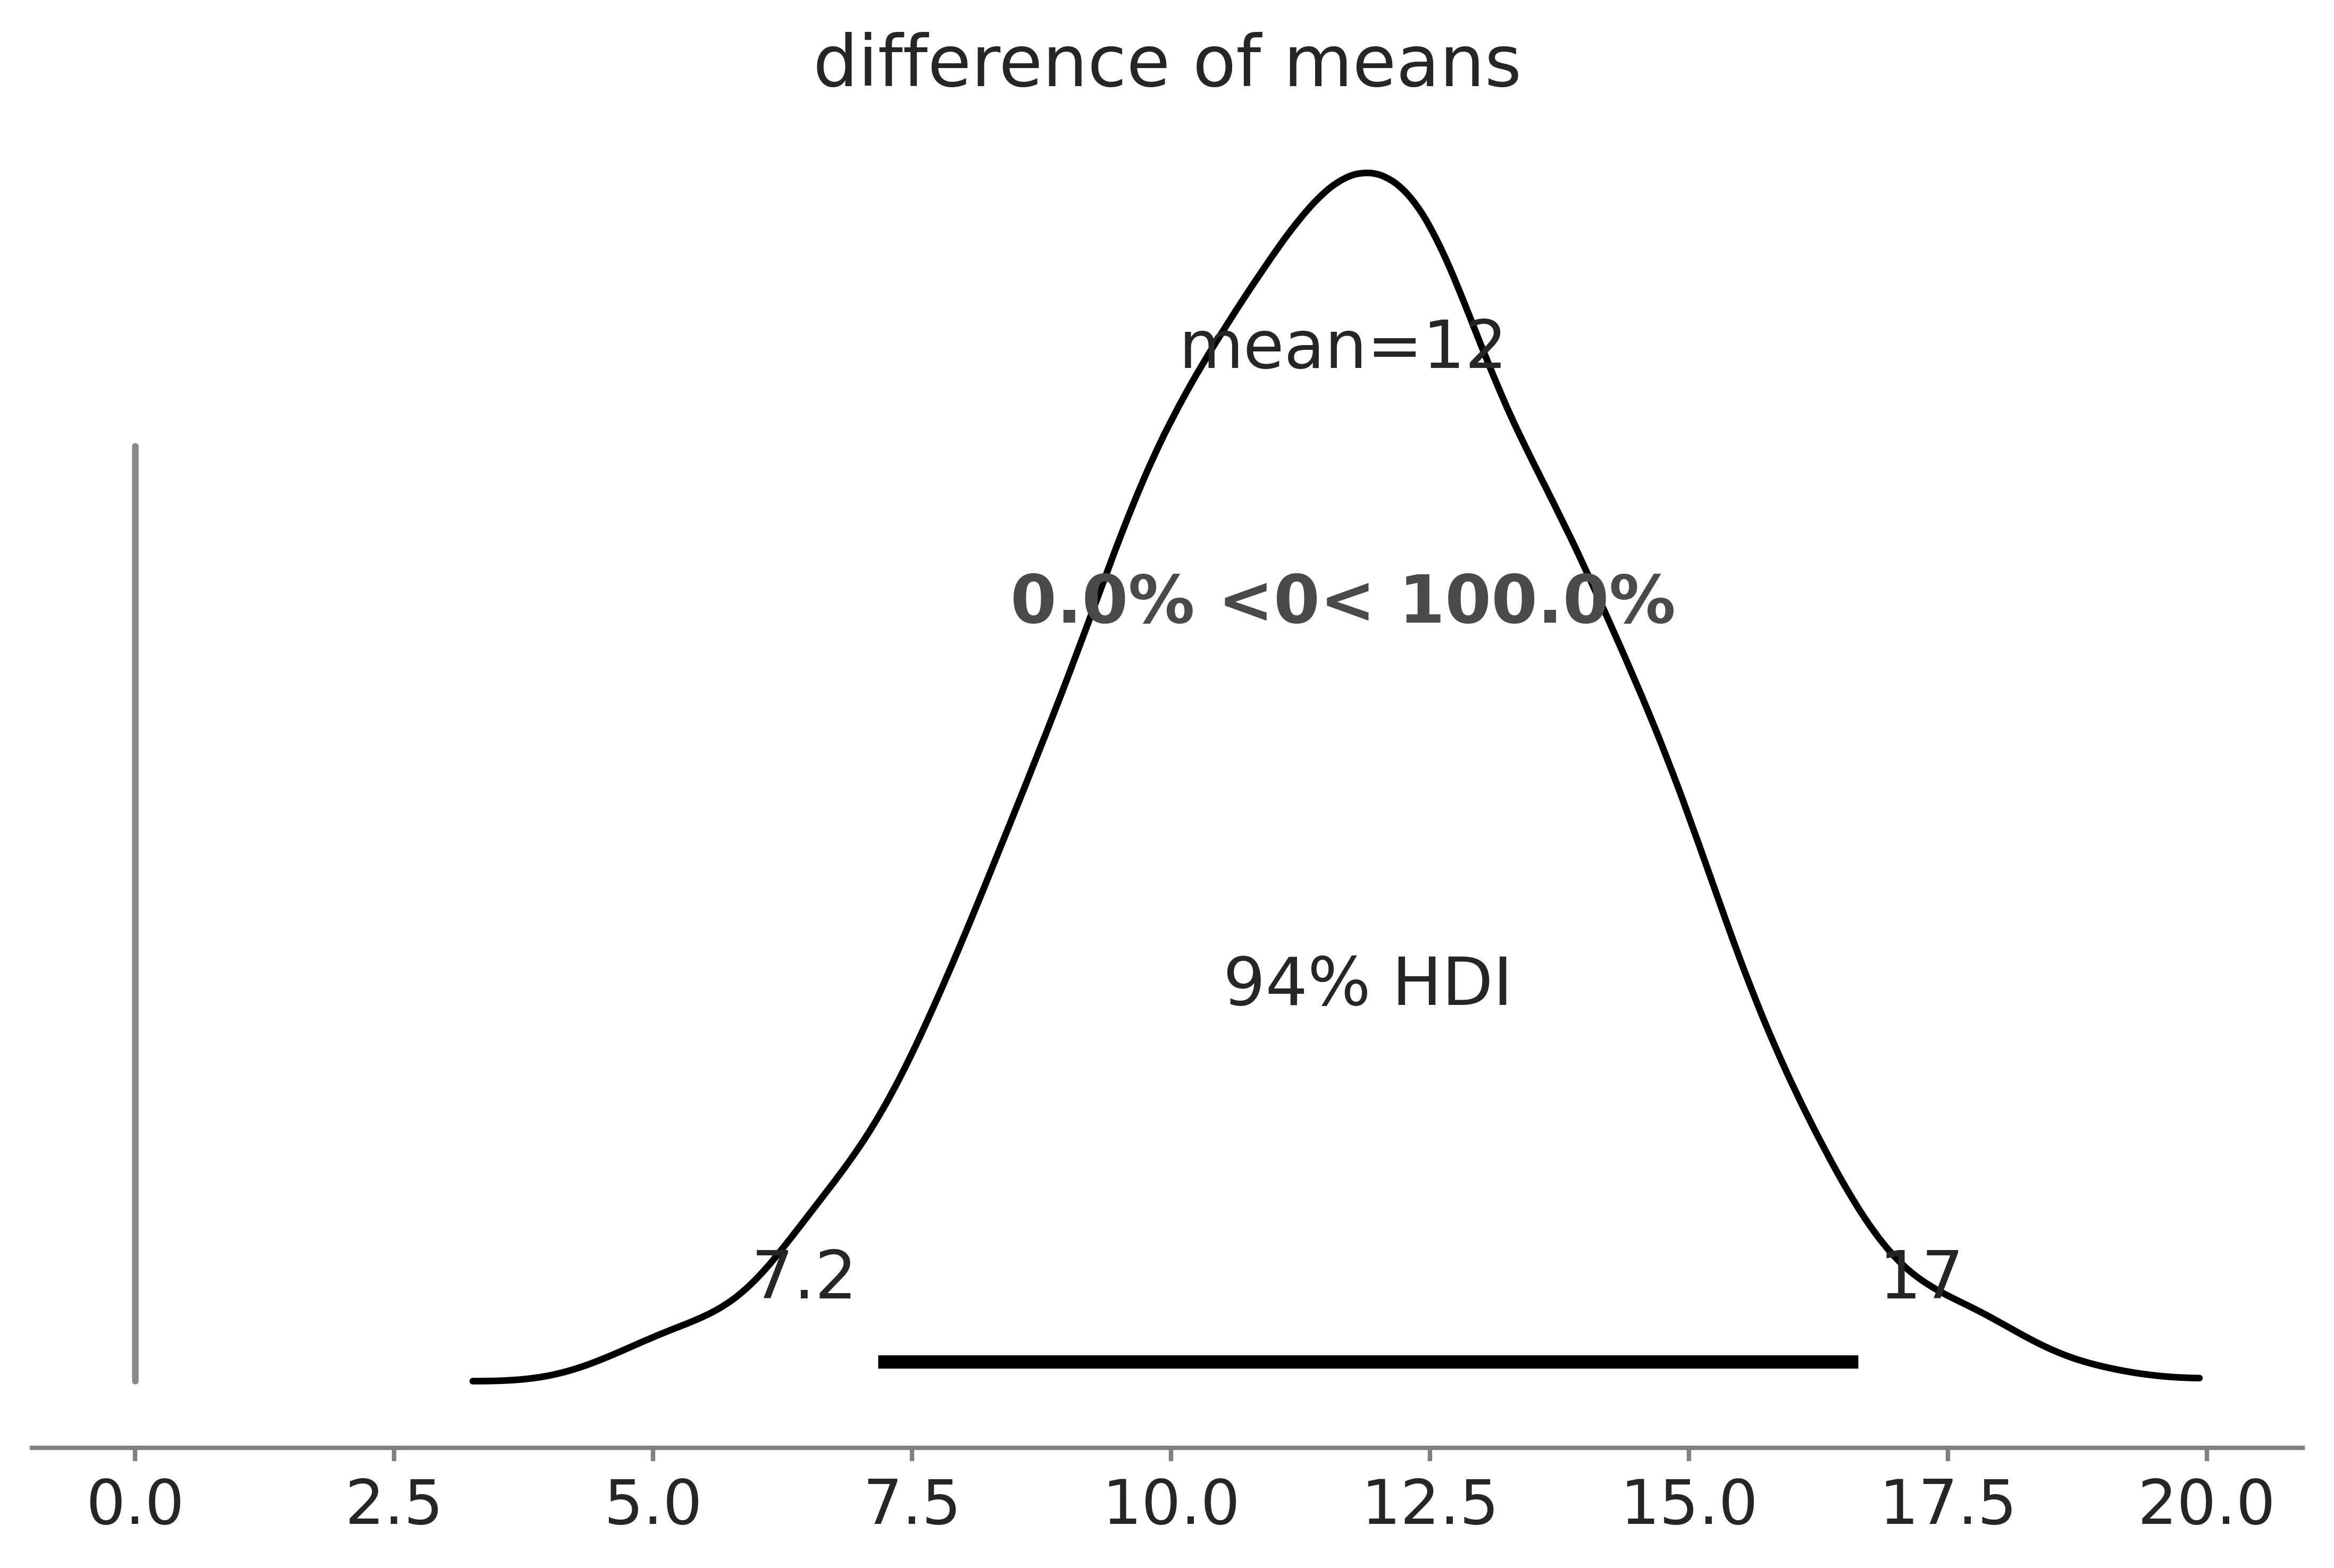

In [17]:
az.plot_posterior(idata, var_names="difference of means", ref_val=0);

La figura seguente mostra la distribuzione a posteriori della grandezza dell'effetto.

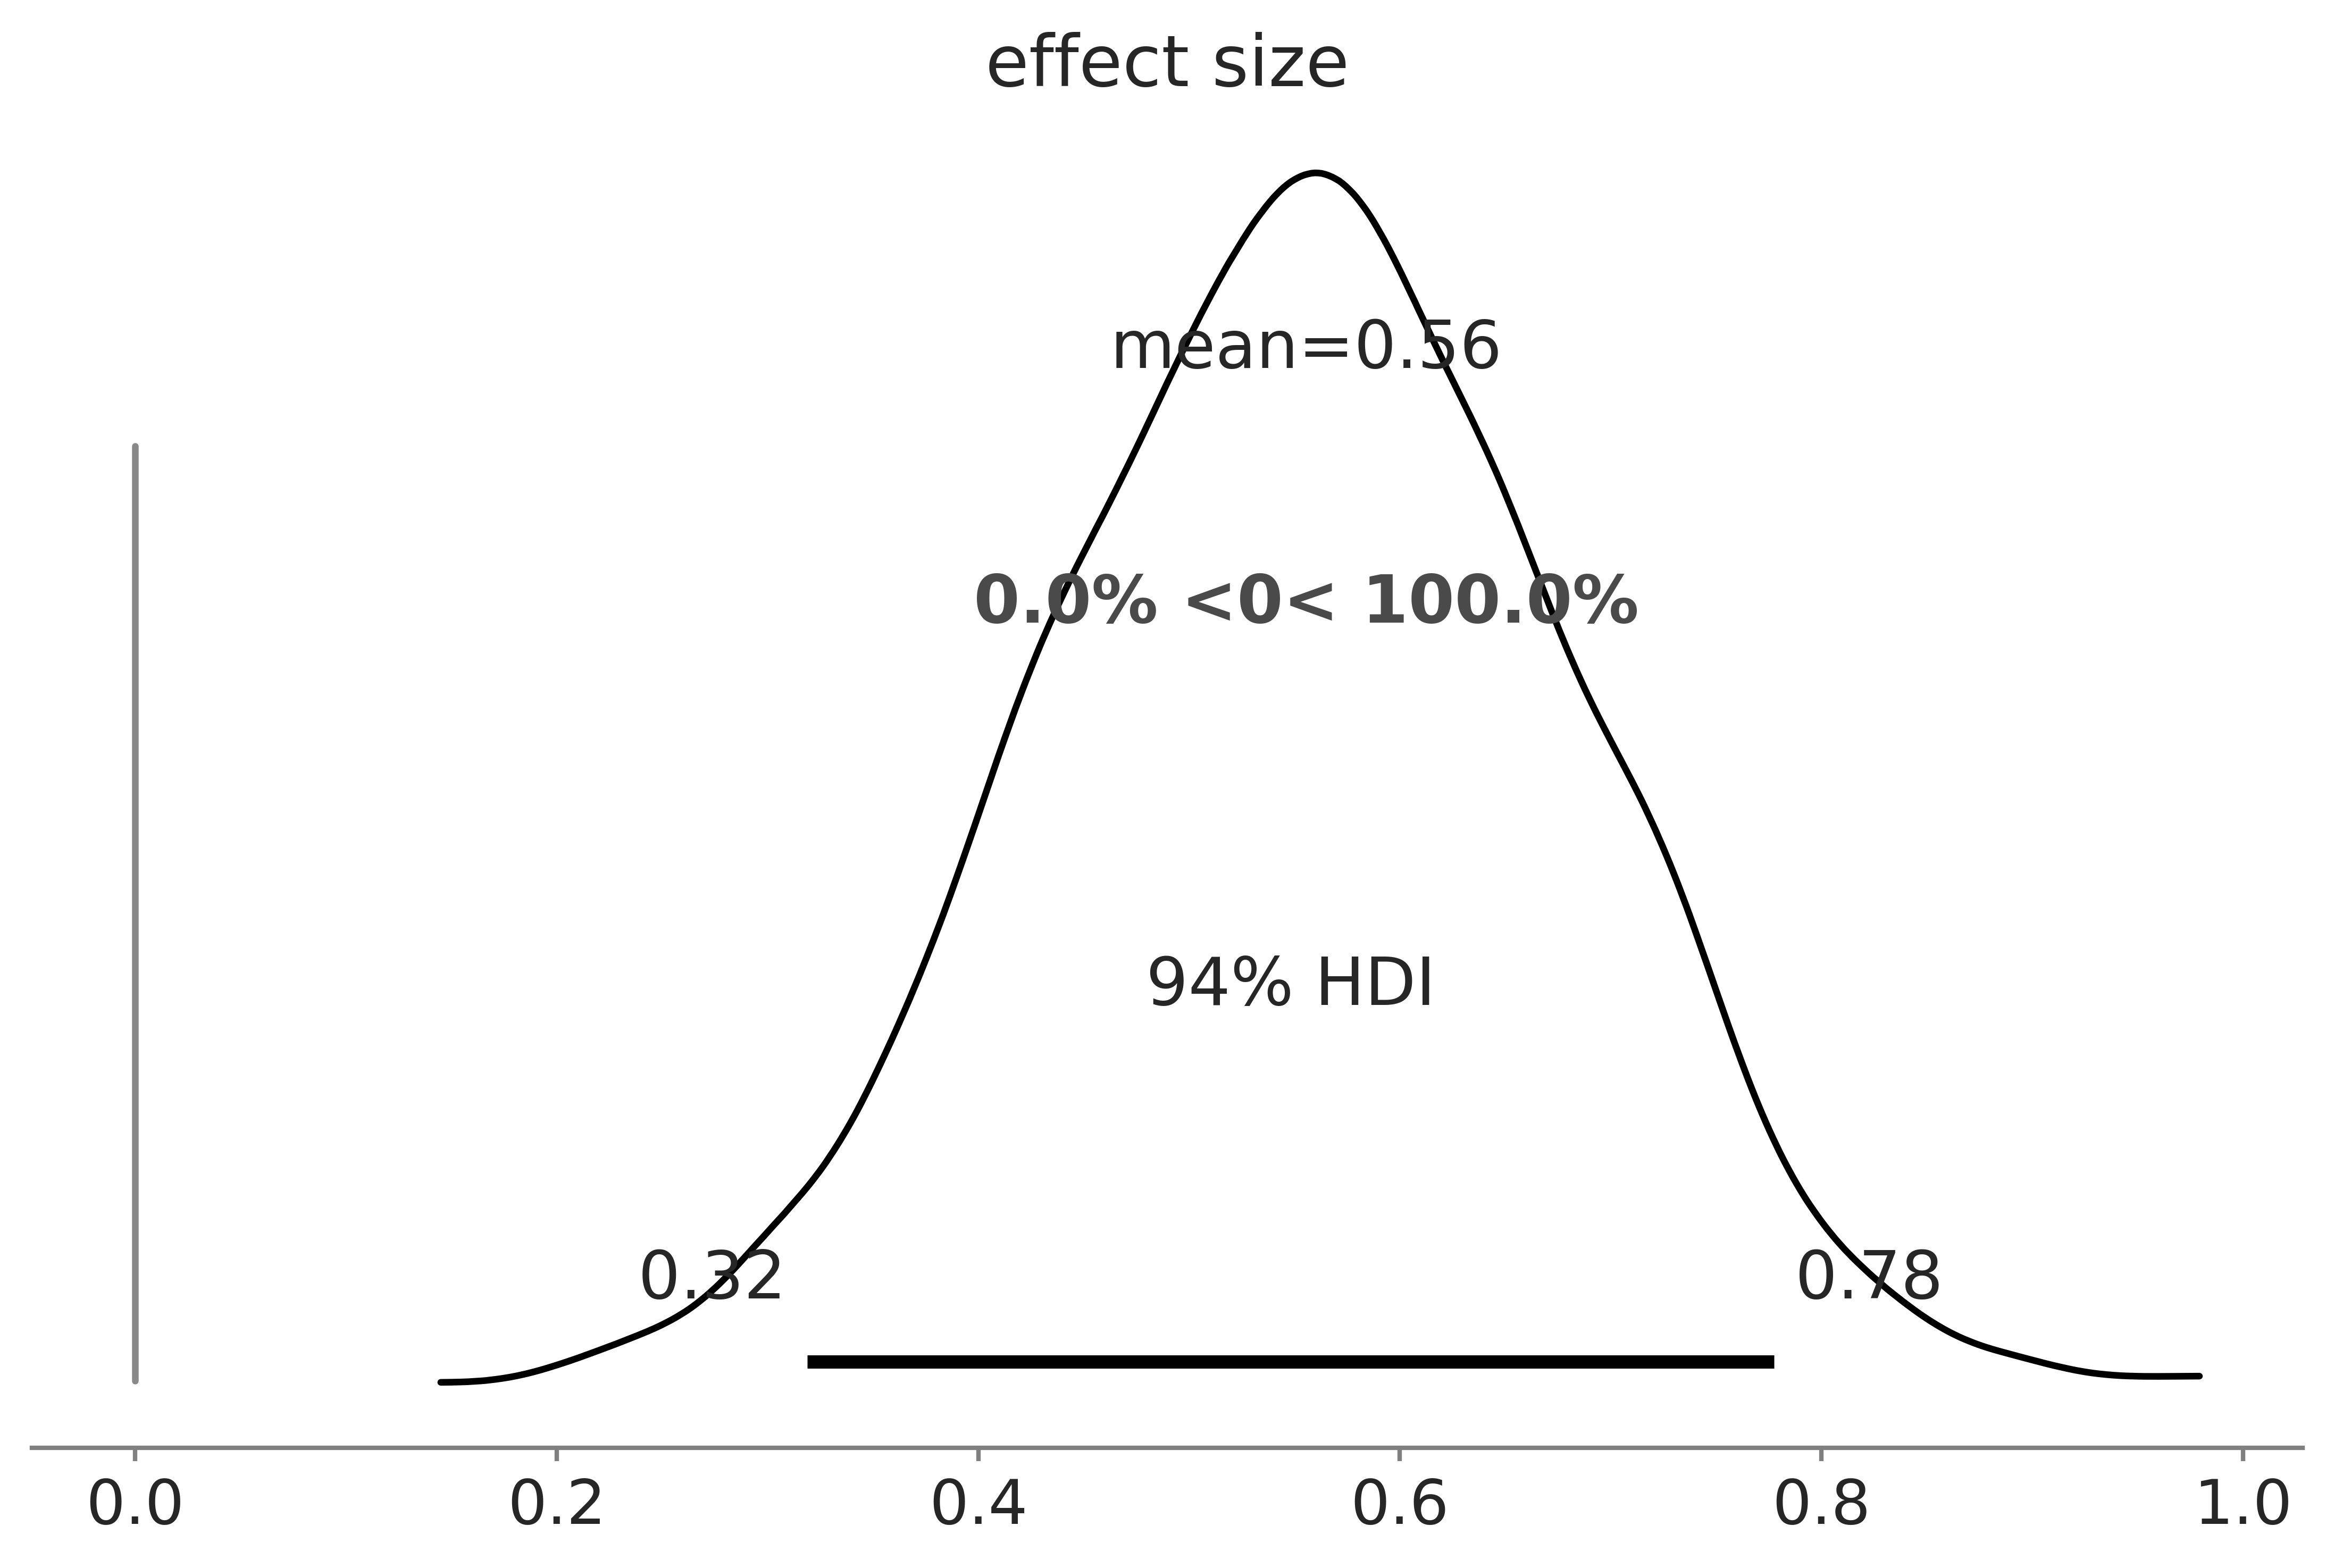

In [18]:
az.plot_posterior(idata, var_names="effect size", ref_val=0);

Possiamo dunque concludere che, per ciò che concerne l'effetto della scolarità della madre sul quoziente di intelligenza del bambino, la dimensione dell'effetto è "media".

## Verifica di ipotesi bayesiana

Come "bonus" di questa analisi statistica, possiamo esaminare l'approccio bayesiano equivalente al test di ipotesi tradizionale.

Dopo aver ottenuto un campione dalla distribuzione a posteriori del parametro di interesse $\mu$ per ciascun gruppo, possiamo porci la domanda: qual è la probabilità che il QI di un bambino in un gruppo sia maggiore di quello di un bambino nell'altro gruppo? Per rispondere a questa domanda, useremo campioni casuali dalle distribuzioni a posteriori dei parametri. Dovremo confrontare le coppie di valori campionati dalle due distribuzioni a posteriori del parametro di interesse e calcolare la media di tali confronti. Questo ci fornirà un'indicazione sulla probabilità che il QI di un bambino in un gruppo sia maggiore di quello di un bambino nell'altro gruppo, basandoci sulla distribuzione a posteriori dei parametri stimati dal modello.

Per recuperare i valori numerici della distribuzione a posteriori del parametro $\mu$ dall'oggetto `idata`, possiamo utilizzare le funzioni di `ArviZ`. Esaminiamo le proprietà dell'oggetto `idata`.

In [165]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Recuperiamo i valori a posteriori della media di ciascuno dei due gruppi.

In [19]:
mu1_post = idata.posterior["group1_mean"]
mu0_post = idata.posterior["group0_mean"]

Per ciacun gruppo, l'oggetto ottenuto è un array di dimensioni $4 \times 1000$. 

In [26]:
mu1_post.shape

(4, 1000)

Una volta ottenute le stime a posteriori dei parametri di interesse per ciascun gruppo, possiamo procedere con il test di ipotesi bayesiano. Ad esempio, ci possiamo chiedere quale sia la probabilità che un bambino la cui madre non ha completato la scuola superiore abbia un QI maggiore di un bambino la cui madre ha completato la scuola superiore.

In [27]:
print(np.mean(mu1_post < mu0_post))

<xarray.DataArray ()>
array(0.)


Una tale probabilità è effettivamente uguale a zero il che conferma il risultato precedente, ovvero l'iportanza del livello di istruzione della madre per il QI del figlio.

## Commenti e considerazioni finali

In questo capitolo abbiamo esaminato la procedura bayesiana per calcolare la distribuzione a posteriori della differenza tra le medie di due gruppi indipendenti. Inoltre, abbiamo esplorato il calcolo della dimensione dell'effetto in termini bayesiani. Nell'esempio trattato, abbiamo considerato il caso in cui la verosimiglianza è descritta da una distribuzione Gaussiana. Tuttavia, va sottolineato che la scelta di una distribuzione specifica per la verosimiglianza non è vincolante nella statistica bayesiana. È possibile utilizzare qualsiasi distribuzione di probabilità, purché sia adeguata ai dati del campione.

Nel caso del confronto tra le medie di due gruppi indipendenti, una distribuzione molto utilizzata è la distribuzione $t$ di Student. Questa distribuzione è particolarmente vantaggiosa quando si desidera condurre un'analisi statistica "robusta", ovvero un'analisi che non sia influenzata da osservazioni anomale o outlier presenti nei dati. Per questo motivo, la distribuzione $t$ di Student è spesso preferita quando si lavora con dati che potrebbero contenere valori anomali.

Per eseguire un'analisi bayesiana utilizzando la distribuzione $t$ di Student per il confronto tra le medie di due gruppi indipendenti, si può fare riferimento al sito di PyMC, dove è disponibile una descrizione dettagliata del modello bayesiano da utilizzare.

## Watermark

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue Sep 05 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.14.2

arviz     : 0.16.1
numpy     : 1.25.2
seaborn   : 0.12.2
pandas    : 2.1.0
matplotlib: 3.7.2
pymc      : 5.7.2

Watermark: 2.4.3

